# Analysis and testing

This notebooks contains the generation, analysis and visualisation of the data accompying Project 1 in FYS4411. Several tests and sanity-checks for the various methods are also included.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.analysis as src
from multiprocessing import Process, Queue
import pandas as pd

%load_ext autoreload
%autoreload 2

#### Testing of blocking method:

For testing, we generate a time-series of random variables that are normally distribued as $X_i = N(0,1)$, but highly corrolated as $X_i = 0.5X_{i-1} + 0.5z$,  $z = N(0,1)$.

In [83]:
np.random.seed(42)
N= 2**18
X = [np.random.normal(0,1)]
for i in range(1, N):
    X.append(0.5*X[-1] + 0.5*np.random.normal(0,1))
X = np.array(X)

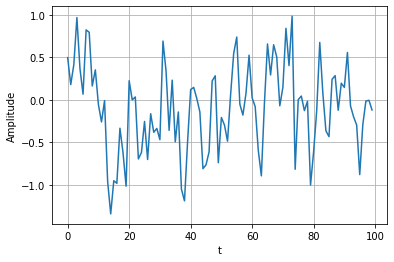

In [84]:
plt.plot(X[:100])
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [85]:
estimatedVar = src.blocking(X, degree = 10)

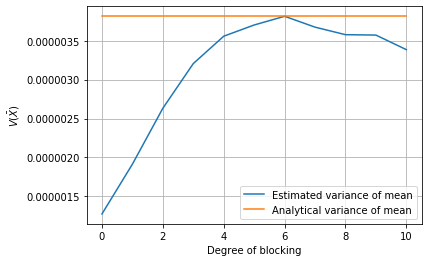

In [97]:
plt.plot(estimatedVar)
plt.plot((0,10), (1/N,1/N))
plt.xlabel("Degree of blocking")
plt.ylabel(r"$V(\bar{X})$")
plt.legend(["Estimated variance of mean", "Analytical variance of mean"])
plt.grid()
plt.show()

#### Investigating the one body density produced when simulating the 1 particle, 1 dimmension system with harmonic oscillator. Brute force and importance sampling are compared to analytical results.

In [98]:
conf = src.config()
conf["numPart"] = 1
conf["numDim"] = 1
conf["numSteps"] = 1000000
conf["stepLength"] = 0.5
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [3]:
src.runner(conf)
_, posBruteForce, _, _ = src.readData(conf)

conf["importanceSampling"] = 1  #switching to importance sampling
src.runner(conf)
_, posImportance, _, _ = src.readData(conf)

Starting simulation
numPart: 1
numDim: 1
numSteps: 1000000
stepLength: 0.5
importanceSampling: 0
alpha: 0.5
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!


Starting simulation
numPart: 1
numDim: 1
numSteps: 1000000
stepLength: 0.5
importanceSampling: 1
alpha: 0.5
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!




Calculating and plotting the densities:

In [4]:
bins = np.linspace(-3, 3, 200)
dx = bins[1] - bins[0]
densityBruteForce = src.oneBodyDensity(posBruteForce[0], bins, mode = "1D")
densityImportance = src.oneBodyDensity(posImportance[0], bins, mode = "1D")

100%|██████████| 1000000/1000000 [00:05<00:00, 193797.71it/s]


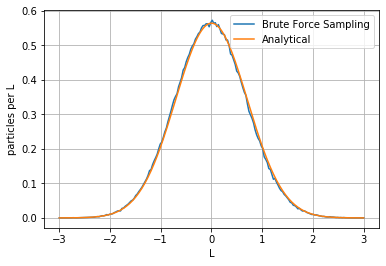

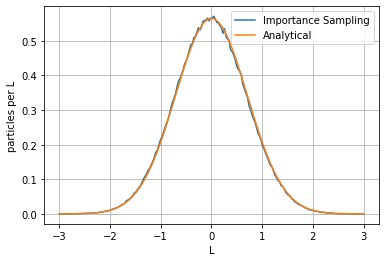

In [5]:
plt.plot(bins, densityBruteForce)
plt.plot(bins, 1/np.sqrt(np.pi)*np.exp(-bins**2))
plt.xlabel("L")
plt.ylabel("particles per L")
plt.legend(["Brute Force Sampling", "Analytical"])
plt.grid()
plt.show()

plt.plot(bins, densityImportance)
plt.plot(bins, 1/np.sqrt(np.pi)*np.exp(-bins**2))
plt.xlabel("L")
plt.ylabel("particles per L")
plt.legend(["Importance Sampling", "Analytical"])
plt.grid()
plt.show()

### Investigating the local energi as a function of alpha for 2 particles, 3 dimmensions in harmonic oscillator. Brute force and importance sampling are used and checked against analytical results to verify the methods works correctly in higher dimmension.

Brute force sampling:

In [139]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 2**17
conf["stepLength"] = 1
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [141]:
x = np.linspace(0.3, 0.8, 21)
E = []
Var = []
for alpha in x:
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    E.append(np.mean(localEnergies[0]))
    Var.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

Done!
Acceptance Rate: 0.405602


Investigating what degree of blocking to use:

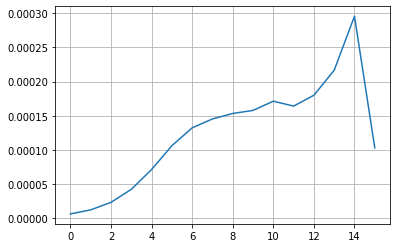

In [142]:
plt.plot(Var[0])
plt.grid()
plt.show()

Plotting estimated energy as a function of alpha for 2 paricles in 3 dimmensions, harmonic oscillator:

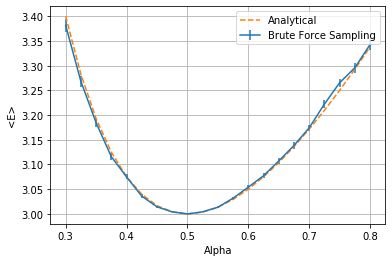

In [143]:
E = np.array(E)
Var = np.array(Var)
std = np.sqrt(Var[:,10])

plt.errorbar(x, E, std)
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--")
plt.xlabel("Alpha")
plt.ylabel("<E>")
plt.legend([ "Analytical","Brute Force Sampling"])

plt.grid()
plt.show()

Importance Sampling:

In [144]:
conf["importanceSampling"] = 1
x = np.linspace(0.3, 0.8, 21)
E = []
Var = []
for alpha in x:
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    E.append(np.mean(localEnergies[0]))
    Var.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

Done!
Acceptance Rate: 0.29998800000000003


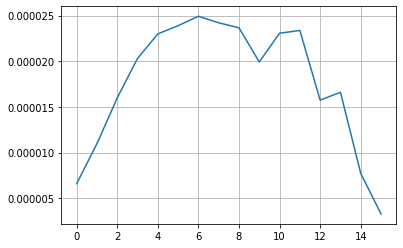

In [145]:
plt.plot(Var[0])
plt.grid()
plt.show()

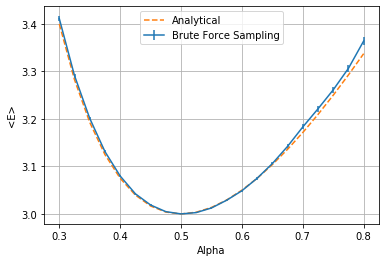

In [146]:
E = np.array(E)
Var = np.array(Var)
std = np.sqrt(Var[:,6])

plt.errorbar(x, E, std)
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--")
plt.xlabel("Alpha")
plt.ylabel("<E>")
plt.legend([ "Analytical","Brute Force Sampling"])

plt.grid()
plt.show()

#### Thermalization of many particals, using Brute Force Sampling and Importance Sampling

In [42]:
conf = src.config()
conf["directory"] = "dataHardshell"
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 1000000
conf["stepLength"] = 0.1
conf["importanceSampling"] = 1

conf["alpha"] = 0.5
conf["a"] = 0.0043
conf["omega"] = 1

conf["InitialState"] = "HardshellInitial"
conf["Wavefunction"] = "HardshellWavefunction"
conf["Hamiltonian"] = "HarmonicOscillator"
src.runner(conf)

In [15]:
localEnergies, _, _, _ = src.readData(conf)

In [16]:
print(np.mean(localEnergies[0]))
print(acceptanceRate)
#plt.plot(localEnergies)
#plt.show()

3.0035027823039995


NameError: name 'acceptanceRate' is not defined

In [ ]:
pos = np.loadtxt("dataHardshell/configuration_0.txt")
x = np.linspace(-3,3,100)
density = src.oneBodyDensity(pos, x, mode = "1D")
plt.plot(x, density)
plt.show()

In [ ]:
conf = {}
conf["directory"] = "data1"
conf["numPart"] = 1
conf["numDim"] = 1
conf["numSteps"] = 1000000
conf["stepLength"] = 1
conf["alpha"] = 0.5
conf["a"] = 1
conf["omega"] = 1

In [ ]:
src.runner(conf)

In [ ]:
localEnergies = np.loadtxt("data1/localEnergies_0.txt")
configurations = np.loadtxt("data1/configuration_0.txt")

plt.plot(localEnergies)
plt.show()

plt.plot(configurations)
plt.show()

x = np.linspace(-4, 4, 200)
dx = x[1] - x[0]

density = src.oneBodyDensity(configurations, x, mode = "1D")
plt.plot(x, density/dx)
plt.plot(x, np.sqrt(1/np.pi)*np.exp(-x**2))
plt.show()
print(np.sum(density))

In [ ]:
alpha = np.linspace(0.3, 0.8, 21)
E = []
var = []
for a in alpha:
    conf["alpha"] = a
    src.runner(conf)
    localEnergies = np.loadtxt("data1/localEnergies_0.txt")
    meanE, varE = src.statistics(localEnergies)
    E.append(meanE)
    var.append(varE)

In [ ]:
plt.plot(alpha, E)
plt.xlabel("alpha")
plt.ylabel("<E>")
plt.show()

plt.plot(alpha, var)
plt.xlabel("alpha")
plt.ylabel("<var>")
plt.show()

In [ ]:
plt.plot(alpha, E)
plt.xlabel("alpha")
plt.ylabel("<E>")
plt.show()

plt.plot(alpha, var)
plt.xlabel("alpha")
plt.ylabel("<var>")
plt.show()

In [ ]:
conf = {}
conf["directory"] = "data1"
conf["numPart"] = 10
conf["numDim"] = 1
conf["numSteps"] = 100000
conf["stepLength"] = 0.1
conf["alpha"] = 0.4
conf["a"] = 1
conf["omega"] = 1

src.runner(conf)

In [ ]:
r = np.linspace(-5, 5, 200)

N = 11


def f(q,i):
    pos = pd.read_csv(f"data1/configuration_{i}.txt", sep ="\n", header = None).values.reshape(-1,2)
    density = src.oneBodyDensity(pos, r, mode = "2D")
    q.put(density)
    
q = Queue()
    
processes = [Process(target = f, args=(q,i)) for i in range(N)]

for p in processes:
    p.start()
 

density = q.get()
for i in range(N-1):
    density += q.get()

density /= N

In [ ]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
ax.pcolormesh(density)
plt.show()

In [ ]:
np.random.seed(42)
N = 1000
signal = np.zeros(N)
signal[0] = np.random.normal(0,1)
for i in range(1, N):
    signal[i] = 0.5*np.random.normal(0,1) + 0.5*signal[i-1]

In [ ]:
plt.plot(signal[:1000])

In [ ]:
var = np.std(signal)**2
print(var)
print(np.sqrt(var/N))

In [ ]:
mean = np.mean(signal)
print(mean)

In [ ]:
corr = 0
for i in range(1000):
    for j in range(i,1000):
        corr += (signal[i] - mean)*(signal[j] - mean)
corr /= 1000

print(corr)

In [ ]:
corr = np.correlate(signal, signal, mode="full")

In [ ]:
plt.plot(corr[999:])

In [ ]:
conf = {}
conf["numPart"] = 10
conf["numDim"] = 3
conf["numSteps"] = 2**20
conf["stepLength"] = 0.1
conf["alpha"] = 0.4

src.runner(conf)
localEnergies = np.loadtxt("localEnergies.txt")

In [ ]:
x = np.copy(localEnergies)
ting = [np.std(x)/np.sqrt(len(x))]
for i in range(16):
    x = src.blocking(x)
    ting.append(np.std(x)/np.sqrt(len(x)))

In [ ]:
plt.plot(ting)

In [ ]:
conf = {}
conf["numPart"] = 10
conf["numDim"] = 1
conf["numSteps"] = 1000
conf["stepLength"] = 0.1
conf["alpha"] = 0.4

mu = 0.001

for i in range(100):
    src.runner(conf)
    gradAlpha = np.loadtxt("metadata.txt")
    print(conf["alpha"])
    conf["alpha"] -= mu*gradAlpha
    